# ==========================================
# 1. Imports, Configuração e Leitura dos Dados
# ==========================================

c:\Users\jaqueline.sousa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Principais variáveis segundo o modelo:


c:\Users\jaqueline.sousa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,feature,importance
0,limite_credito,189
8,fatura_mes1,180
1,idade,175
16,pagto_mes3,140
22,proporcao_pago_3,138
20,proporcao_pago_1,138
24,proporcao_pago_5,136
23,proporcao_pago_4,135
15,pagto_mes2,131
14,pagto_mes1,128


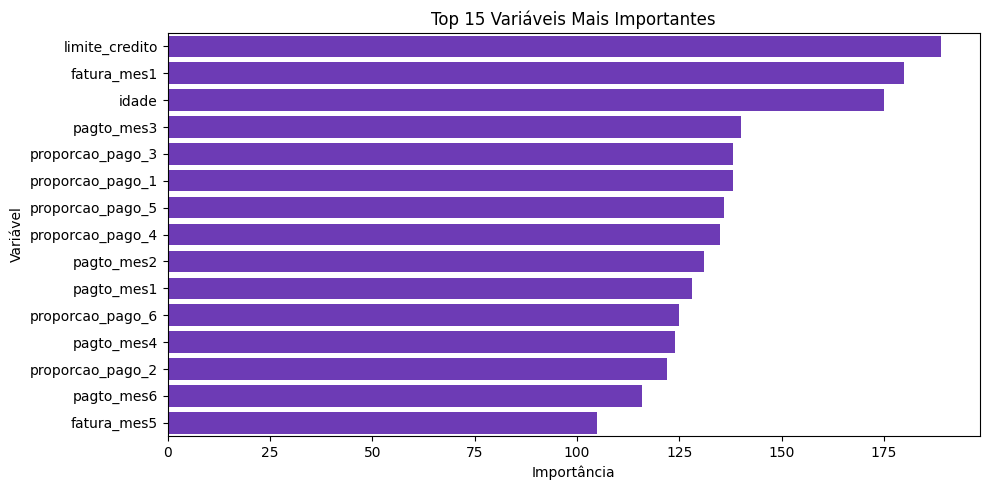

✅ Arquivo 'shap_values_clientes.csv' salvo!
✅ Arquivo 'previsoes_clientes.csv' exportado.
✅ Arquivo 'feature_importance.csv' exportado.

Todos arquivos para Power BI foram gerados com sucesso! 🚀


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import locale
import shap
import os

from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from joblib import load

# Locale brasileiro para formatação
try:
    locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')
except:
    try:
        locale.setlocale(locale.LC_ALL, 'Portuguese_Brazil.1252')
    except:
        pass

os.makedirs('img', exist_ok=True)
os.makedirs('export', exist_ok=True)

# Leitura dos dados e resultados
df = pd.read_csv('export/dataset_preparado_para_modelo.csv')
resultados = pd.read_csv('export/modelos_resultados.csv')
melhor_pipe = load('export/melhor_modelo.joblib')

X = df.drop(['inadimplente', 'id'], axis=1)
y = (df['inadimplente'] == 'Sim').astype(int)
y_pred = melhor_pipe.predict(X)
y_proba = melhor_pipe.predict_proba(X)[:, 1]

# ==========================================
# 2. Explicabilidade: Feature Importance
# ==========================================
# Tenta recuperar nomes das features pós-OHE
try:
    onehot_feat_names = melhor_pipe.named_steps['pre'].transformers_[1][1].named_steps['encoder'].get_feature_names_out(
        melhor_pipe.named_steps['pre'].transformers_[1][2]
    )
    all_feature_names = (
        melhor_pipe.named_steps['pre'].transformers_[0][2] + list(onehot_feat_names)
    )
except Exception as e:
    print("⚠️ Não foi possível recuperar nomes das variáveis categóricas:", e)
    all_feature_names = X.columns.tolist()

# Feature importance só para modelos tree-based
fi = None
if hasattr(melhor_pipe.named_steps['clf'], "feature_importances_"):
    importancias = melhor_pipe.named_steps['clf'].feature_importances_
    fi = pd.DataFrame({'feature': all_feature_names, 'importance': importancias})
    fi = fi.sort_values('importance', ascending=False)
    print("Principais variáveis segundo o modelo:")
    display(fi.head(15))

    # Gráfico de importância
    plt.figure(figsize=(10, 5))
    sns.barplot(x='importance', y='feature', data=fi.head(15), color="#6927c9")
    plt.title('Top 15 Variáveis Mais Importantes')
    plt.xlabel('Importância')
    plt.ylabel('Variável')
    plt.tight_layout()
    plt.savefig('img/feature_importance.png', dpi=160)
    plt.show()

# ==========================================
# 3. Explicabilidade Local: SHAP (opcional, mas recomendado!)
# ==========================================
try:
    # Para modelos que suportam (Random Forest, LightGBM, XGBoost, DecisionTree)
    explainer = shap.Explainer(melhor_pipe.named_steps['clf'])
    X_proc = melhor_pipe.named_steps['pre'].transform(X)
    shap_values = explainer(X_proc)
    plt.figure(figsize=(12, 5))
    shap.summary_plot(shap_values, features=X_proc,
                      feature_names=all_feature_names, show=False)
    plt.tight_layout()
    plt.savefig('img/shap_summary.png', dpi=160)
    plt.close()

    # Exporta SHAP values
    shap_df = pd.DataFrame(shap_values.values, columns=all_feature_names)
    shap_df['id'] = df['id']
    shap_df['inadimplente_real'] = df['inadimplente']
    shap_df['prob_pred'] = y_proba
    shap_df['predito'] = np.where(y_pred == 1, 'Sim', 'Não')
    shap_df.to_csv('export/shap_values_clientes.csv', index=False)
    print("✅ Arquivo 'shap_values_clientes.csv' salvo!")
except Exception as e:
    print("⚠️ SHAP não pôde ser executado para esse modelo:", e)

# ==========================================
# 4. Exportação dos Outputs Finais para Power BI
# ==========================================

# 4.1. Tabela de previsões por cliente
df_out = df.copy()
df_out['prob_pred_inadimplente'] = y_proba
df_out['predito_inadimplente'] = np.where(y_pred == 1, 'Sim', 'Não')
df_out.to_csv('export/previsoes_clientes.csv', index=False)
print("✅ Arquivo 'previsoes_clientes.csv' exportado.")

# 4.2. Tabela das principais variáveis do modelo
if fi is not None:
    fi.to_csv('export/feature_importance.csv', index=False)
    print("✅ Arquivo 'feature_importance.csv' exportado.")

print("\nTodos arquivos para Power BI foram gerados com sucesso! 🚀")
